In [1]:
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf
from time import time

/home/tking/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import cv2

from scipy.misc import imresize
from skimage.transform import resize

import glob

import matplotlib.pyplot as plt
%matplotlib inline

from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
import random
from keras import optimizers

In [3]:
# remove invaild images(only run once) 
# for img in glob.glob(r"../../images/plant/*.jpg"):
#     n= cv2.imread(img)#BGR
#     if  n is None or np.mean(n)>250 or np.mean(np.std(n,axis=2))<2:
#         os.remove(img)

In [4]:
def generator(batch_size, dir_path, H, W):
    while True:
#         img_all = []
        X = []
        Y = []
        img_batch = random.sample(glob.glob(dir_path), batch_size)
        for img in img_batch:
            # choose random index in features
            n= cv2.imread(img)#BGR
            m = imresize(n,(H,W,3))
            img_lab = cv2.cvtColor(m.astype(np.uint8), cv2.COLOR_BGR2LAB)
            L = img_lab[:,:,0].reshape(1,H,W,1)
#             img_all.append(m)
            y = np.floor(img_lab[:,:,1:]/16)

            # to_categorical
            y0=y[:,:,0].flatten()
            y1=y[:,:,1].flatten()
            Yc2d0 = to_categorical(y0, num_classes = 16 )
            Yc3d0 = Yc2d0.reshape(H,W,16)
            Yc2d1 = to_categorical(y1, num_classes = 16 )
            Yc3d1 = Yc2d1.reshape(H,W,16)
            Yc3d = np.zeros((H,W,32))
            Yc3d[:,:,:16] = Yc3d0
            Yc3d[:,:,16:] = Yc3d1

            Y.append(Yc3d)
            X.append(L)
        X=np.array(X)
        Y=np.array(Y)
        X=np.reshape(X, (batch_size, H, W, 1))
        Y=np.reshape(Y, (batch_size, H, W, 32))
        yield X, Y

In [5]:
def XY2img(X,Y):
    H, W, _ = X.shape
    img_lab = np.zeros((H,W,3))
    img_lab[:,:,0] = X[:,:,0]
    img_lab[:,:,1] = np.argmax(Y[:,:,:16],axis=2)*16+8
    img_lab[:,:,2] = np.argmax(Y[:,:,16:],axis=2)*16+8
    img = cv2.cvtColor(img_lab.astype(np.uint8), cv2.COLOR_LAB2RGB)
    return img

/home/tking/.local/lib/python3.5/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.


(-0.5, 399.5, 399.5, -0.5)

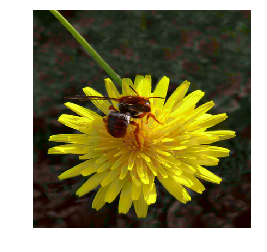

In [6]:
# test if generator and XY2img work
X,Y = generator(1, r"../../images/flower/*.jpg", 400, 400).__next__()
img = XY2img(X[0],Y[0])
plt.imshow(img)
plt.axis('off')

In [7]:

H = 64
W = 64
train_dir = r"../../images/flower/train/*.jpg"
test_dir = r"../../images/flower/test*.jpg"

In [8]:
# read images to compute class_weight
# img_all = []
# X = []
Y = []
for img in glob.glob(train_dir):
    n= cv2.imread(img)#BGR
    m = imresize(n,(H,W,3))
    img_lab = cv2.cvtColor(m.astype(np.uint8), cv2.COLOR_BGR2LAB)
#     L = img_lab[:,:,0].reshape(1,H,W,1)
#     img_all.append(m)
    y = np.floor(img_lab[:,:,1:]/16)
    
    # to_categorical
    y0=y[:,:,0].flatten()
    y1=y[:,:,1].flatten()
    yc2d0 = to_categorical(y0, num_classes = 16 )
    yc3d0 = yc2d0.reshape(H,W,16)
    yc2d1 = to_categorical(y1, num_classes = 16 )
    yc3d1 = yc2d1.reshape(H,W,16)
    yc3d = np.zeros((H,W,32))
    yc3d[:,:,:16] = yc3d0
    yc3d[:,:,16:] = yc3d1

    Y.append(yc3d)
#     X.append(L)
#     if len(Y)==num:
#         break

/home/tking/.local/lib/python3.5/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


In [9]:
num = len(Y)
Y=np.array(Y)
Y=np.reshape(Y, (num, H, W, 32))

In [10]:
# compute class_weight
from sklearn.utils import class_weight
Yflat16A = Y[:,:,:,:16].reshape(num*H*W,16)
YflatA = np.argmax(Yflat16A,axis=1)
YclassA = np.unique(YflatA)
class_weight_A = class_weight.compute_class_weight('balanced',
                                                 YclassA,
                                                 YflatA)
Yflat16B = Y[:,:,:,16:].reshape(num*H*W,16)
YflatB = np.argmax(Yflat16B,axis=1)
YclassB = np.unique(YflatB)
class_weight_B = class_weight.compute_class_weight('balanced',
                                                 YclassB,
                                                 YflatB)

class_weight = np.zeros(32)# ones or zeros?
for i in range(len(YclassA)):
    class_weight[YclassA[i]]=class_weight_A[i]
for i in range(len(YclassB)):
    class_weight[YclassB[i]+16]=class_weight_B[i]

print(class_weight)

[0.00000000e+00 0.00000000e+00 4.20102564e+04 1.33932805e+02
 2.39283784e+01 1.98824335e+00 4.56828533e-01 2.06168106e-01
 2.55026992e-01 1.44831323e+00 2.79925303e+00 3.45611718e+00
 7.22736376e+00 8.50410049e+01 3.15076923e+04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.55111111e+04 1.05921903e+02
 1.80838852e+01 6.32655268e+00 2.67722917e+00 8.74149007e-01
 2.43799946e-01 3.16529306e-01 5.71936836e-01 1.24170880e+00
 2.88727232e+00 1.01458968e+01 0.00000000e+00 0.00000000e+00]


In [11]:
# Building the neural network
import keras.backend as K
K.clear_session()
model = Sequential()
model.add(InputLayer(input_shape=(None, None, 1)))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='sigmoid', padding='same'))#TODO
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 1)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 8)     80        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 8)     584       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 16)    1168      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 16)    2320      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 32)    4640      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, None, None, 32)    9248      
__________

In [12]:
# compile model
opt = optimizers.Adam(lr=0.001)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
batch_size = 32
train_dir = r"../../images/flower/train/*.jpg"
test_dir = r"../../images/flower/test/*.jpg"

train_generator = generator(batch_size, train_dir, H, W)
test_generator = generator(batch_size, test_dir, H, W)
tr_size = len(glob.glob(train_dir))
ts_size = len(glob.glob(test_dir))
steps_per_epoch = tr_size// batch_size
validation_steps = ts_size // batch_size
print(tr_size,ts_size,steps_per_epoch,validation_steps)

400 200 12 6


In [14]:
# TODO change to fit_generator
t0 = time()
hist = model.fit_generator(train_generator,
                            steps_per_epoch=steps_per_epoch,
                            epochs=100,
                            validation_data=test_generator,
                            validation_steps=validation_steps,
                            class_weight=class_weight)
                            #callbacks=[EarlyStopping(patience=5)])
print('Train time: %.fm'%((time()-t0)/60))

Epoch 1/100


/home/tking/.local/lib/python3.5/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.


12/12 [==============================] - 4s 340ms/step - loss: 6.5866 - acc: 0.0184 - val_loss: 5.8427 - val_acc: 0.0193
Epoch 2/100
12/12 [==============================] - 2s 206ms/step - loss: 5.4607 - acc: 0.0182 - val_loss: 5.0794 - val_acc: 0.0160
Epoch 3/100
12/12 [==============================] - 3s 213ms/step - loss: 4.8990 - acc: 0.0213 - val_loss: 4.9544 - val_acc: 0.0197
Epoch 4/100
12/12 [==============================] - 3s 211ms/step - loss: 4.9073 - acc: 0.0238 - val_loss: 4.9480 - val_acc: 0.0339
Epoch 5/100
12/12 [==============================] - 3s 213ms/step - loss: 4.8820 - acc: 0.0336 - val_loss: 4.7968 - val_acc: 0.0349
Epoch 6/100
12/12 [==============================] - 3s 212ms/step - loss: 4.7931 - acc: 0.0433 - val_loss: 4.8248 - val_acc: 0.0487
Epoch 7/100
12/12 [==============================] - 3s 222ms/step - loss: 4.7757 - acc: 0.0477 - val_loss: 4.7654 - val_acc: 0.0382
Epoch 8/100
12/12 [==============================] - 3s 212ms/step - loss: 4.6878

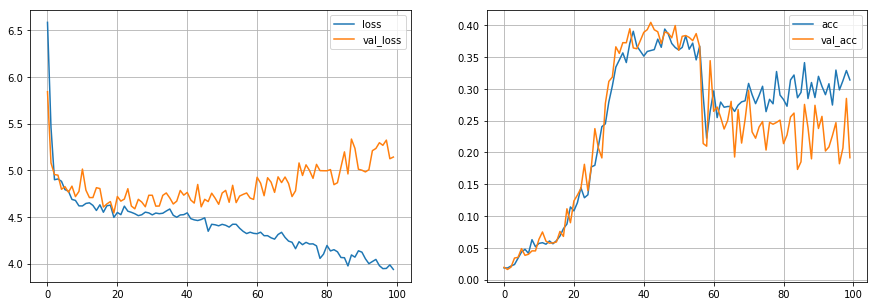

In [15]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.grid()
plt.subplot(1,2,2)
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['acc','val_acc'])
plt.grid()

In [21]:
model_json = model.to_json()
with open("model_CW_flower_tr400_bs32_ep100.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model_CW_flower_tr400_bs32_ep100.h5")

In [17]:
from keras.models import model_from_json

In [18]:
json_file = open('model_CW_flower_tr400_bs32_ep100.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_CW_flower_tr400_bs32_ep100.h5")

/home/tking/.local/lib/python3.5/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.


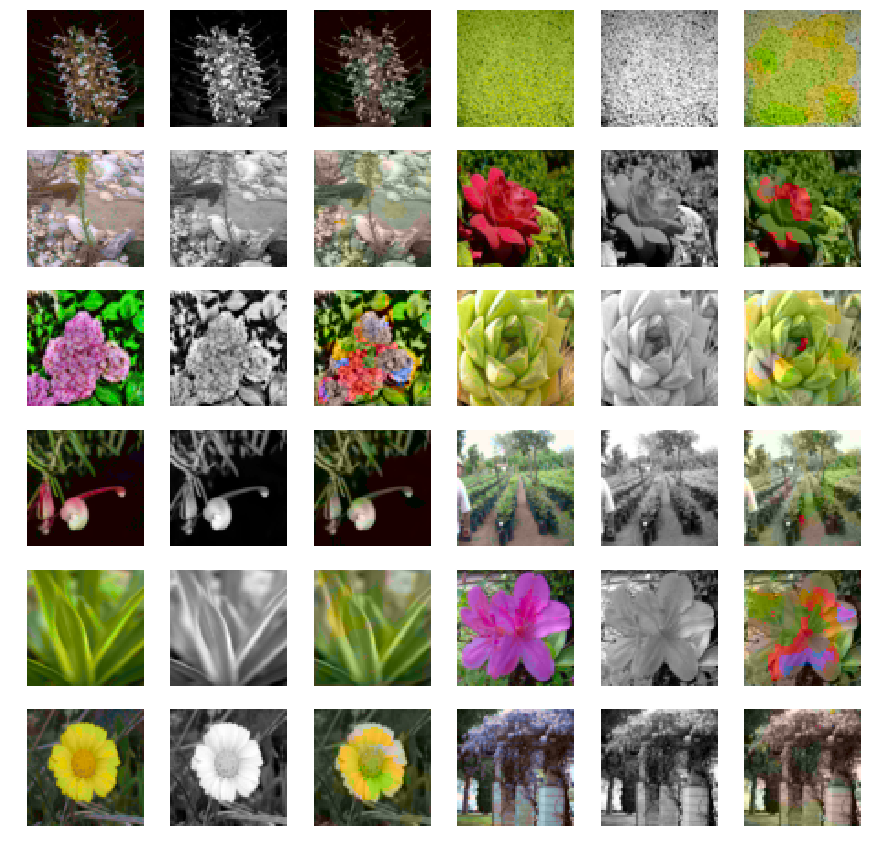

In [19]:
# result on train images
X,Y = generator(batch_size, train_dir, H, W).__next__()
Yhat = loaded_model.predict(X)
j =1
plt.figure(figsize=(15,15))
for i in range(12):
    # original
    plt.subplot(6,6,j)
    j+=1
    img = XY2img(X[i],Y[i])
    plt.imshow(img)
    plt.axis('OFF')
    # grayscale
    plt.subplot(6,6,j)
    j+=1
    plt.imshow(X[i,:,:,0],'gray')
    plt.axis('OFF')
    # predict
    plt.subplot(6,6,j)
    j += 1
    img = XY2img(X[i],Yhat[i])
    plt.imshow(img)
    plt.axis('OFF')

/home/tking/.local/lib/python3.5/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.


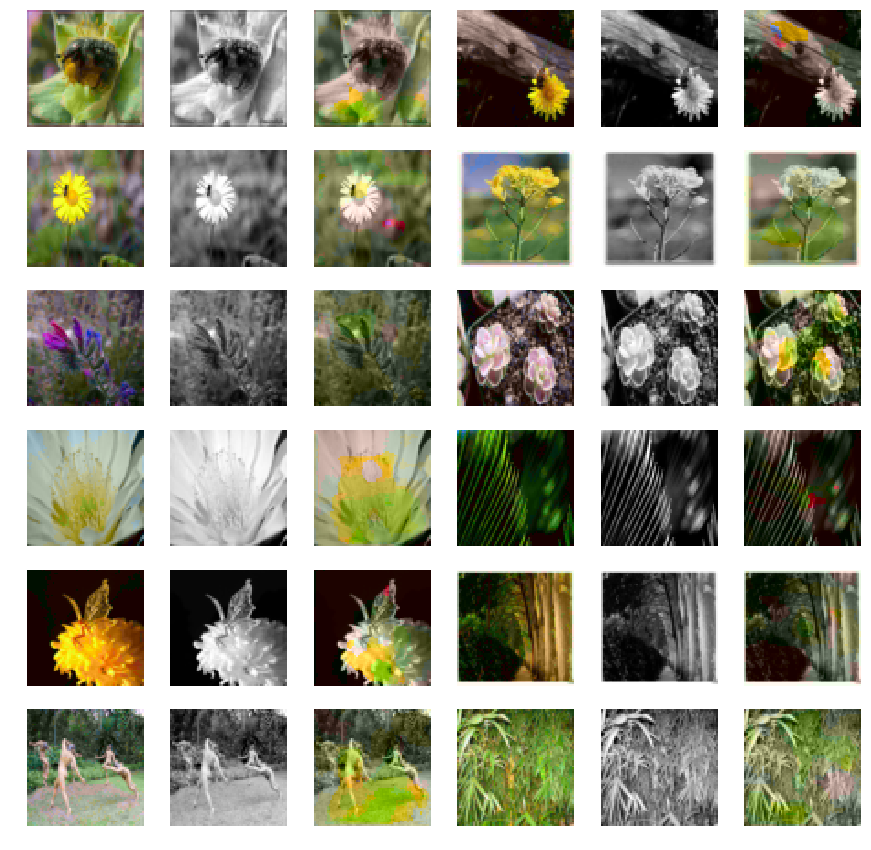

In [20]:
# result on test images
X,Y = generator(batch_size, test_dir, H, W).__next__()
Yhat = loaded_model.predict(X)
j =1
plt.figure(figsize=(15,15))
for i in range(12):
    # original
    plt.subplot(6,6,j)
    j+=1
    img = XY2img(X[i],Y[i])
    plt.imshow(img)
    plt.axis('OFF')
    # grayscale
    plt.subplot(6,6,j)
    j+=1
    plt.imshow(X[i,:,:,0],'gray')
    plt.axis('OFF')
    # predict
    plt.subplot(6,6,j)
    j += 1
    img = XY2img(X[i],Yhat[i])
    plt.imshow(img)
    plt.axis('OFF')